In [22]:
# import libraries

# basics

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import datetime

# nlp

import spacy

# Keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Bidirectional,\
                                    Conv1D, MaxPooling1D, Dropout, Activation, Embedding

# preprocessing and model validation

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, FeatureAgglomeration
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,\
                            confusion_matrix, plot_confusion_matrix,\
                            silhouette_score

In [2]:
# read in the dataset

df = pd.read_json('../data/cleaned/json.json')

In [3]:
# check the data

print(df.shape)
df.head()

(102031, 13)


,subreddit,author,date,post,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,lemmatized,vectors
0,alcoholism,glorybellpirate,2020-01-01,Day 1 of sobriety Feeling anxious and letting ...,0,0,1,0,0,24,3,day 1 of sobriety feel anxious and let the fee...,"[-0.026765203100000003, 0.2515704036, -0.15668..."
1,alcoholism,EhndlessSl0th,2020-01-01,"Started the New Year with a bang. Hey, I'm new...",0,1,1,0,1,577,41,start the new year with a bang hey -pron- be n...,"[0.0102483444, 0.18354494870000002, -0.2263026..."
2,alcoholism,the_kinky_penguin,2020-01-01,Why can't I get drunk anymore I've been a heav...,0,0,1,0,0,64,5,why ca not -pron- get drunk anymore -pron- hav...,"[-0.09739924970000001, 0.1839587241, -0.227181..."
3,alcoholism,SauceoffSauceOn,2020-01-01,I am an Alcoholic. How do I quit? I have been ...,0,0,1,0,1,111,14,-pron- be an alcoholic how do -pron- quit -pro...,"[-0.0117096035, 0.1865714192, -0.2576603591, -..."
4,alcoholism,ben42187,2020-01-01,Funniest Thing about Alcoholism With every oth...,0,0,1,0,0,136,9,funniest thing about alcoholism with every oth...,"[-0.0443742387, 0.1812106818, -0.1554362029000..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102031 entries, 0 to 102030
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   subreddit      102031 non-null  object        
 1   author         102031 non-null  object        
 2   date           102031 non-null  datetime64[ns]
 3   post           102031 non-null  object        
 4   covid_related  102031 non-null  int64         
 5   suicidal       102031 non-null  int64         
 6   alc_abuse      102031 non-null  int64         
 7   loneliness     102031 non-null  int64         
 8   stress         102031 non-null  int64         
 9   n_words        102031 non-null  int64         
 10  n_sentences    102031 non-null  int64         
 11  lemmatized     102031 non-null  object        
 12  vectors        102031 non-null  object        
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 10.9+ MB


In [5]:
# check vectors column

df['vectors'][0][0]

-0.026765203100000003

In [6]:
len(df['vectors'][0])

300

In [7]:
type(df['vectors'][0][0])

float

In [8]:
# check for nulls

df.isnull().sum()

subreddit        0
author           0
date             0
post             0
covid_related    0
suicidal         0
alc_abuse        0
loneliness       0
stress           0
n_words          0
n_sentences      0
lemmatized       0
vectors          0
dtype: int64

In [ ]:
# create a variable to take mean vectors

vec_mean = []

for i in range(len(df['vectors'])):
    
    mean = np.mean(df['vectors'][i])
    vec_mean.append(mean)
    
df['vector_mean'] = vec_mean

df['vector_mean'][:5]

In [ ]:
df.head()

## Preprocessing and clustering

In [9]:
# df['vectors'] to a dataframe

X = pd.DataFrame(data = list(df['vectors']), columns = list(range(1, 301)))

### with PCA

In [10]:
# first reduce dimensionality before feeding to t-sne

pca = PCA(n_components = 50)
X_pca = pca.fit_transform(X) 

#### t-sne

In [11]:
# reduce dimensionality again with t-sne (perplexity = 25.0 -- half of components number after PCA)

tsne_25 = TSNE(n_components = 2, perplexity = 25.0, n_iter = 2000, verbose = 1).fit_transform(X_pca)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 102031 samples in 0.430s...
[t-SNE] Computed neighbors for 102031 samples in 924.539s...
[t-SNE] Computed conditional probabilities for sample 1000 / 102031
[t-SNE] Computed conditional probabilities for sample 2000 / 102031
[t-SNE] Computed conditional probabilities for sample 3000 / 102031
[t-SNE] Computed conditional probabilities for sample 4000 / 102031
[t-SNE] Computed conditional probabilities for sample 5000 / 102031
[t-SNE] Computed conditional probabilities for sample 6000 / 102031
[t-SNE] Computed conditional probabilities for sample 7000 / 102031
[t-SNE] Computed conditional probabilities for sample 8000 / 102031
[t-SNE] Computed conditional probabilities for sample 9000 / 102031
[t-SNE] Computed conditional probabilities for sample 10000 / 102031
[t-SNE] Computed conditional probabilities for sample 11000 / 102031
[t-SNE] Computed conditional probabilities for sample 12000 / 102031
[t-SNE] Computed conditional proba

In [12]:
# create a dataframe with the result

df_t25 = pd.DataFrame(tsne_25, columns = ['comp1', 'comp2'])

df_t25

,comp1,comp2
0,57.794609,0.075915
1,2.754512,41.383049
2,-8.959167,-0.764163
3,-23.645781,-30.258425
4,39.918255,34.540653
...,...,...
102026,-17.487741,46.642063
102027,-25.012796,10.051959
102028,-53.463299,27.987040
102029,33.898098,5.831940


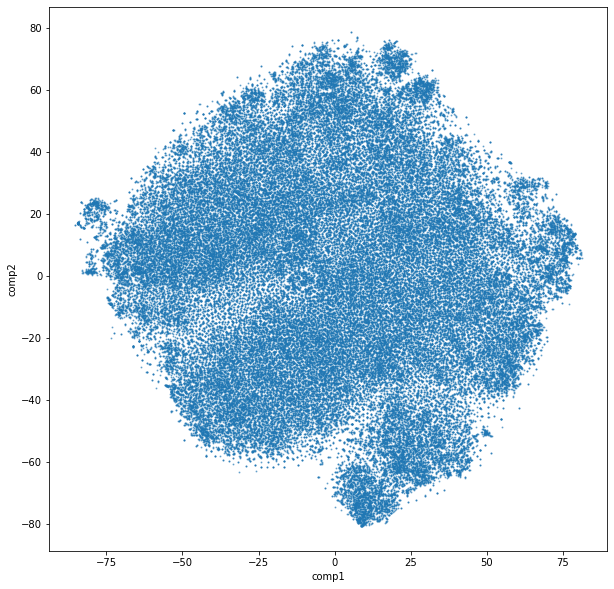

In [15]:
# plot the result

df_t25.plot(kind = 'scatter', x = 'comp1', y = 'comp2', s = 1, alpha = 0.5, figsize = (10, 10));

#### K-Means

In [20]:
# find the best k

scores = []

for k in range(2, 10):
    
    # cluster
    km = KMeans(n_clusters = k, random_state = 2020)
    km.fit(X_pca)
    
    # silhouette score
    sil = silhouette_score(X_pca, km.labels_)
    
    # append to a list
    scores.append((k, sil))

In [21]:
# store the score with k to a dataframe

k_scores = pd.DataFrame(scores, columns = ['k', 'sil'])

k_scores

,k,sil
0,2,0.116491
1,3,0.097101
2,4,0.057650
3,5,0.057526
4,6,0.056842
5,7,0.055472
6,8,0.046898
7,9,0.042894


#### Feature Agglomerative Clustering

In [23]:
# instantiate feature agglomerative clustering

fa = FeatureAgglomeration(n_clusters = 2)

# fit model and predict clusters

X_fa = fa.fit_transform(X_pca)

In [24]:
X_fa.shape

(102031, 2)

In [26]:
X_fa[:5]

array([[ 0.03946312, -0.69460721],
       [-0.00164312, -0.02467937],
       [-0.00110124, -0.09072182],
       [ 0.00987699,  0.02668293],
       [ 0.00811135, -0.3236834 ]])

In [35]:
fa.labels_

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [34]:
# print the result

for i, label in enumerate(set(fa.labels_)):
    
    features_with_label = [j for j, lab in enumerate(fa.labels_) if lab == label]
    
    print(f'Features in agglomeration {i}: \n{features_with_label}')

Features in agglomeration 0: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Features in agglomeration 1: 
[0]


In [ ]:
### -> it seems the first vector is grouped as 1, and everything else as 0. it